In [115]:
import nltk
import pandas as pd
import numpy as np
import re
import string
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read Medium data
top_articles = pd.read_json('top_health_articles.json')
top_articles.head()

,date,tags,title,author,claps,length,url,corpus
52,2018-01-17,"[life, design, entrepreneur, ideas, health]",Adversity is the Mother of Invention,Pierre-Emmanuel Boiton,533,7,https://medium.com/@peboiton/adversity-is-the-...,"Four years ago, I had an accident. The kind of..."
104,2018-01-17,"[feminism, sex, rape, health, wellbeing]",5 Stories of Affirmative Consent,Devon Price,1723,8,https://medium.com/@devonprice/5-nice-stories-...,I.He was in town visiting for a conference. We...
131,2018-01-17,"[fitness, wellness, health, exercise, aging]",Injury prevention gets harder as you age. Thes...,Washington Post,567,5,https://medium.com/thewashingtonpost/injury-pr...,"By Carolee Belkin WalkerBaby, it’s cold outsid..."
154,2018-01-17,"[food, psychology, diet, health, motivation]",The Amazing One-Apple-A-Day Diet,Gabriel Iosa,785,3,https://medium.com/@gabrieliosa/the-amazing-on...,"I’m not talking Apple the company, but apple t..."
186,2018-01-16,"[politics, food, history, health, economics]",Top Ramen and the Historical Narratives Impact...,Laura LeMoon,1229,4,https://medium.com/@lauralemoon/top-ramen-and-...,"As I cook my nightly Top Ramen, it occurs to m..."


In [3]:
# Clean corpi for text analysis
def clean(text):
    text = text.lower()
    text = re.sub('\n','',text) 
    text = re.sub('[.*?\â£]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

top_articles['clean_corpus'] = top_articles['corpus'].apply(clean)
top_articles['clean_corpus'].iloc[0]

#clean_corpus = [clean(corpus)]
#clean_corpus

'four years ago i had an accident the kind of accident that can change your life this accident has been the starting point for creating a new product i thought that it was the right time to share a little bit more of this story with you todayi was spending the weekend with my friends in aixlesbains aixlesbains is a charming little town in france with a beautiful lake my friends own a boat there and as it was a sunny day we decided to spend the saturday afternoon sailing on the lakeat one point we discovered a nice cliff so we decided to climb it and then jump into the water the water was so crystal clear there it felt so inviting moreover the cliff was not too high around  meters so it didn’t look too dangerous my friends jumped first then it was my turn when i jumped i was afraid to hurt my back on the rocks behind me to avoid injuring myself i decided to jump as far as possible but i got unbalanced and landed in the water on my bottomright after the jump my back felt sore i lay down 

In [4]:
# Get word counts
def counter_df(clean_corpus):
    cv = CountVectorizer(ngram_range = (1,1), stop_words='english')
    data_cv = cv.fit_transform(clean_corpus)
    return pd.DataFrame(data={'word':cv.get_feature_names(), 'count':data_cv.toarray().sum(axis=0)})

data_df = counter_df(list(top_articles['clean_corpus']))
data_df.head()

#print(cv.get_feature_names())

,word,count
0,aa,9
1,aaem,1
2,aafa,2
3,aah,1
4,aalst,4


In [73]:
# Correlating text to colors that affect mood
color_db = {
    'purple_negative': ['mystery', 'mysterious', 'moodiness', 'moody', 'boredom', 'bored', 'bore', 'confusion', 'confuse', 'confused', 'disconnection', 'disconnect'],
    'purple_positive': ['connection', 'connect', 'wisdom', 'wise', 'spirituality', 'spiritual', 'royalty', 'royal, ''nobility', 'noble', 'luxury', 'luxurious', 'ambition', 'ambitious', 'wealth', 'wealthy', 'awaken', 'awake'],
    'blue_negative': ['coldness', 'cold', 'masculinity', 'masculine', 'male', 'disgust', 'disgusted', 'conflict', 'conflicting', 'aggression', 'aggressive'],
    'blue_positive': ['intuition', 'imagination', 'imagine', 'tranquility', 'tranquil', 'security', 'secure', 'integrity', 'peace', 'peaceful', 'loyalty', 'loyal', 'faith', 'faithful', 'intelligence', 'intelligent'],
    'teal_negative': ['femininity', 'feminine', 'female', 'hostility', 'hostile'],
    'teal_positive': ['communication', 'communicate', 'expression', 'express', 'healing', 'heal', 'protection', 'protect', 'sophisticated', 'cleanse', 'cleansing'],
    'green_negative': ['envy', 'envious', 'jealousy', 'jealous', 'guilt', 'guilty', 'fear', 'fearful', 'scared', 'judgmental', 'judge', 'judging', 'unforgiving', 'anxiety', 'anxious'],
    'green_positive': ['compassion', 'trust', 'freshness', 'fresh', 'environment', 'new', 'money', 'fertile', 'health', 'healthy', 'grounded', 'reconnecting', 'balanced', 'balance', 'balancing'],
    'yellow_negative': ['irresponsible', 'instability', 'grief', 'grieve', 'grieving', 'grieves', 'addiction', 'addict', 'addicted', 'insecurity', 'insecure', 'depression', 'depressed'],
    'yellow_positive': ['confident', 'confidence', 'bright', 'sunny', 'energetic', 'warm', 'happy', 'happiness', 'perky', 'joy', 'joyful', 'intellect', 'intellectual'],
    'orange_negative': ['ignorance', 'ignorant', 'sluggishness', 'sluggish', 'shame', 'ashamed', 'shameful', 'compulsiveness', 'compulsive', 'loneliness', 'lonely', 'alone', 'dependence', 'dependent'],
    'orange_positive': ['courage', 'friendliness', 'friendly', 'success', 'successful', 'creativity', 'creative', 'openness', 'open', 'sexual', 'sexy', 'sex'],
    'red_negative': ['anger', 'angry', 'unsafe', 'warned', 'warn', 'warning', 'worry', 'worried', 'volatile', 'hopelessness', 'hopeless'],
    'red_positive': ['love', 'loving', 'passion', 'passionate', 'energy', 'energetic', 'power', 'powerful', 'strength', 'strong', 'heat', 'hot', 'desire', 'safe', 'safety', 'instinctive', 'instinct', 'security', 'secure', 'liberating', 'liberate']
}
def find_color(word):
    for key in color_db.keys():
        if word in color_db[key]:
            return key
    return ''
            
data_df['color'] = data_df['word'].apply(find_color)
data_df = data_df.loc[data_df['color'] != ''].copy()
data_count = data_df.groupby('color').sum()
data_count

,count
color,
blue_negative,870
blue_positive,1243
green_negative,2013
green_positive,10624
orange_negative,629
orange_positive,2780
purple_negative,365
purple_positive,1084
red_negative,1007


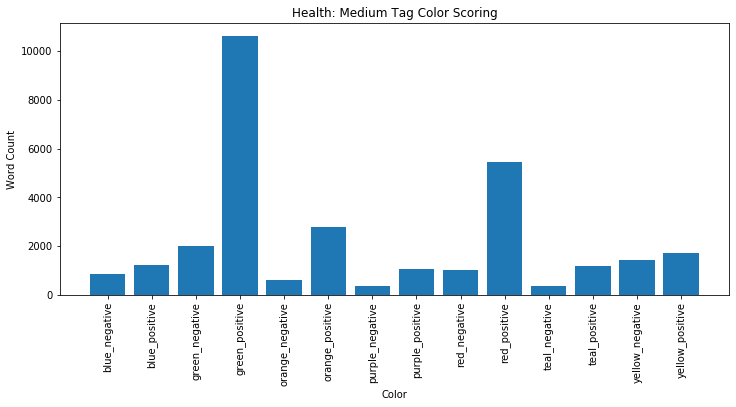

In [132]:
# Plot word count by color
fig, ax = plt.subplots(figsize=(12,5))
ax.bar(data_count.index, data_count['count'])
ax.tick_params(axis='x', rotation=90)
ax.set_title('Health: Medium Tag Color Scoring')
ax.set_xlabel('Color')
ax.set_ylabel('Word Count')
plt.show()

In [75]:
# Find two-w
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()

cv_unigram = CountVectorizer(ngram_range = (1,1), stop_words='english')
cv_bigram = CountVectorizer(ngram_range = (2,2), stop_words='english')

def unigram_themes(data):
    data_cv_stop = cv_unigram.fit_transform(data)
    transformed_weights = transformer.fit_transform(data_cv_stop)
    weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
    weights_df = pd.DataFrame({'term': cv_unigram.get_feature_names(), 'weight': weights})
    return weights_df.sort_values(by='weight', ascending=False).head(7)
    
def bigram_themes(data):
    data_cv_stop = cv_bigram.fit_transform(data)
    transformed_weights = transformer.fit_transform(data_cv_stop)
    weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
    weights_df = pd.DataFrame({'term': cv_bigram.get_feature_names(), 'weight': weights})
    return weights_df.sort_values(by='weight', ascending=False).head(7)

#unigram_themes(clean_corpus)
bigram_themes(list(top_articles['clean_corpus']))

,term,weight
858234,weight loss,0.003608
879330,written bywritten,0.003531
493765,mental health,0.003229
218250,don know,0.003157
280963,feel like,0.003128
218860,don want,0.002722
463954,lose weight,0.002493


In [76]:
# Aggregate color word counts
data_words = data_df.groupby('color').apply(lambda x: dict(zip(x['word'], x['count']))).rename('words')
data = data_count.join(data_words)
data

,count,words
color,,
blue_negative,870,"{'aggression': 18, 'aggressive': 56, 'cold': 4..."
blue_positive,1243,"{'faith': 123, 'faithful': 4, 'imagination': 4..."
green_negative,2013,"{'anxiety': 678, 'anxious': 155, 'envious': 7,..."
green_positive,10624,"{'balance': 363, 'balanced': 107, 'balancing':..."
orange_negative,629,"{'ashamed': 69, 'compulsive': 21, 'dependence'..."
orange_positive,2780,"{'courage': 64, 'creative': 167, 'creativity':..."
purple_negative,365,"{'bore': 13, 'bored': 54, 'boredom': 21, 'conf..."
purple_positive,1084,"{'ambition': 16, 'ambitious': 18, 'awake': 119..."
red_negative,1007,"{'anger': 118, 'angry': 163, 'hopeless': 23, '..."


['green_positive', 'red_positive', 'orange_positive', 'green_negative', 'yellow_positive']


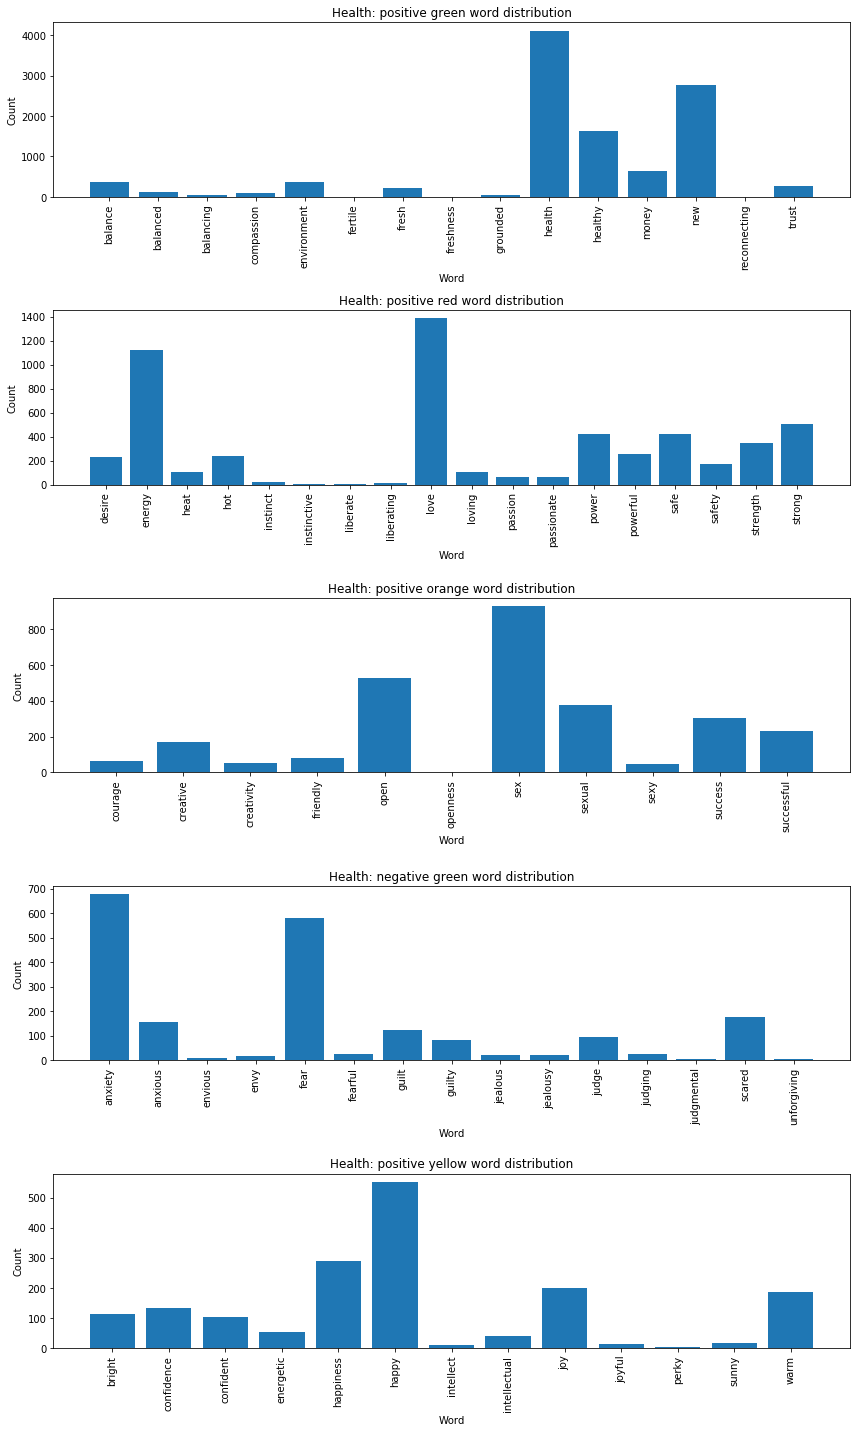

In [129]:
x = 5
top_x = list(data.sort_values('count', ascending=False).index[:x])
print(top_x)

fig, axs = plt.subplots(x, figsize=(12,x*4))
for k, input in enumerate(top_x):
    axs[k].bar(*zip(*data.loc[input, 'words'].items()))
    args = input.split('_')
    axs[k].set_title('Health: ' + args[1] + ' ' + args[0] + ' word distribution')
    axs[k].set_xlabel('Word')
    axs[k].set_ylabel('Count')
    axs[k].tick_params(axis='x', rotation=90)
fig.tight_layout()
plt.show()